<hr>
<h1> Regressão Logística Aplicada ao SASD Memory Effect </h1>
<hr>

<h2><strong>Resumo</strong></h2>
Utilizando variáveis que são pertinentes ao SASD memory effect e ao clima regional do estado de São Paulo, montamos um modelo de regressão logística para predizer o sinal das anomalias de temperatura entre Junho e Agosto, com aproximadamente um ano de antecedência. O ajuste apresentou, dentro do conjunto de treinamento, valores de acurácia, precisão e recall de aproximadamente 70%. Ao analizarmos apenas situações de neutralidade de El Nino - Oscilação Sul e SASD, observamos, no teste do modelo, uma performace geral de aproximadamente 80%. Notamos que, embora ENSO e SASD sejam conhecidos por seus efeitos no continente sulamericano, o modelo apontou para o SASD, ocorrido no ano anterior, como seu principal componente preditivo. Isso indica a importância do SASD memory effect para o clima regional do sudeste brasileiro e evidencia o potencial de seu uso como indicador preditivo.


<h2><strong>Introdução</strong></h2>


<strong>Sobre o SASD Memory Effect:</strong>

Existe um padrão de variabilidade acoplada chamado Dipolo Subtropical do Atlântic Sul (SASD, do inglês) que conecta a variabilidade atmosférica (variabilidade da Alta Subtropical) com a variabilidade das anomalias de temperatura da superfície do mar (TSM) no Atlântico Sul.

Santis et al. 2020 descreveu que, quando um evento de SASD ocorre durante o inverno-primavera, existe um processo oceânico que armazena as anomalias de TSM em camadas mais produndas do oceano, e que no ano seguinte retornam à superfície. Esse processo constitui um efeito de memória ao SASD.

Muito bem. O efeito de memória traz imediatamente a idéia de previsibilidade. Seria possível então, dado um evento de SASD na época certa, predizer que no ano seguinte observaremos condições específicas, determinadas por esse efeito de memória. Posteriormente, foi verificado que as anomalias de TSM que retornam no ano seguinte impactam na atmosfera. Especificamente, anomalias de temperatura do ar em superfície são observadas no estado de São Paulo entre junho, julho e agosto, e estão associadas ao efeito de memória. Vamos aqui aplicar um modelo de regressão logística ao SASD memory effect, com o intuito de  estimar a probabilidade de, dado um evento de SASD num determinado inverno-primavera, observarmos anomalias quentes ou frias sobre o estado de São Paulo no inverno do ano subsequente.

<strong> Sobre a Regressão Logística:</strong>

A regressão logistica nos oferece um modelo regressor para variáveis categóricas, como por exemplo Y = (SIM , NÃO), Y = (Sucesso , Fracasso). 

A regressão nos dá, pois, a chance de um conjunto de observações ($X$) resultarem em uma determinada classe admitida por Y. O ajuste se dá com o uso da função sigmoide, dada por:

Função de ajuste: $\sigma(z) = \frac{1}{1+e^{-z}}$

donde:
<li>$z=\beta^T X $
<li>$\beta= \beta_0, \beta_1 , \beta_2, ..., \beta_n $ são coeficientes da função de ajuste</li>
<li>$X= X_1 , X_2 , ..., X_n $ são as variáveis independentes</li>
<li>$\beta^T X= \beta_0+ \beta_1 X_1 , \beta_2 X_2 , ..., \beta_n X_n $ é a combinação linear de todas as variáveis independentes</li>

O que se faz na regressão logistica é encontrar os coeficientes $\beta$ que maximizam a verossimilhança, ou, equivalentemente, minimizam a função custo (erro).



<h1> Objetivo do Estudo: </h1>

Aplicar o modelo de Regressão Logística</strong> ao SASD memory effect, para verificarmos se conseguimos predizer o sinal das anomalias de temperatura sobre São Paulo, entre Junho e Julho, com cerca de um ano de antecedência.

Assim, temos:

- Y = sinal da anomalia de temperatura do ar sobre o estado de São Paulo (aproximadamente), tomada entre Junho e Agosto;

    Defino Y=0 para anomalias negativas, e Y=1 para anomalias positivas;

<h2> É preciso estabelecer quais variáveis ($X$) são relevantes ao problema.</h2>
<li><h3> Vamos elencar inicialmente três variáveis independentes: </li>
   

<li>$X_1$: SASDIy0[julho ano 0], precursora do efeito de memória;</li>
<li>$X_2$: SASDIy1[julho ano 1]; pode influenciar o clima na região de interesse</li>
<li>$X_3$: ENSO[julho ano 1]; pode influenciar o clima na região de interesse</li>

- SASDI é uma medida do SASD (SASD Index), e é o prinpical índice envolvido no efeito de memória. O SASDI é medido como a diferença das anomalias entre cada pólo do dipolo (polo sudoeste menos polo nordeste);
- ENSO é o índice do El Nino - Oscilação Sul, e é incluído por seus conhecidos impactos no clima regional sulamericano;
- SASD no ano 1 também é incluído, pois também pode influenciar o valor de Y;

<strong>IMPORTANTE</strong> notar que: SASDIy0 é tomado em julho de um determinado ano (ano 0), enquanto que Y, SASDIy1 e ENSO são tomados entre junho e agosto do ano seguinte (ano 1). Há, portanto, aproximadamente um ano de diferença entre SASDIy0 e Y.

<hr>
<h2>Código:</h2>

Importando as bibliotecas necessárias ...

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score, recall_score, precision_score, confusion_matrix, auc

<hr>
Função para abrir os arquivos netcdf.



In [2]:
def openfiles():
    # Dados começam todos em 15 jan 1980.
    Sdata= xr.open_dataset('data/MEAN_SASDb.nc')
    Edata= xr.open_dataset('data/Nino3b_ERv5.nc')
    Tdata= xr.open_dataset('data/TSP_anom.nc')
    sasdi=np.array(Sdata['MEDIAB'][:])
    nino3=np.array(Edata['NINO3B'][:])
    #p1=np.array(Pdata['PREC01'][:])
    #p2=np.array(Pdata['PREC02'][:])
    tanom=np.array(Tdata['TANOM'][:])
    return sasdi,nino3,tanom

<hr><strong> Vamos </strong> olhar para as séries temporais de SASDI, ENSO e Tanom:

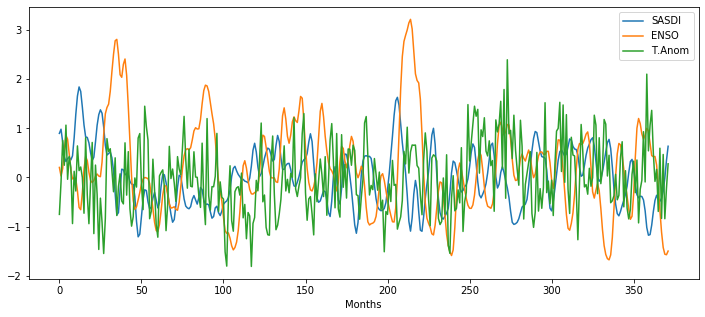

In [3]:
sasda,ninoa,tanoma=openfiles()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))  

l1,=ax.plot(sasda,label='SASDI')
l2,=ax.plot(ninoa,label='ENSO')
l3,=ax.plot(tanoma,label='T.Anom')
plt.xlabel('Months')
ax.legend([l1,l2,l3], ['SASDI','ENSO','T.Anom'])



<hr>
Vou selecionar as seguintes variáveis

- SASDIy0: índice do SASD em Julho de cada ano (ano 0);
- SASDIy1: índice do SASD em Julho do ano seguinte (y1) 
- ENSO: índice do El Nino - Oscilação Sul,  em Julho (ano 1) 
- Tanom: Anomalia de temperatura sobre o estado de São Paulo (ano 1).

Em seguinda, transformo Tanom (Real) em binário (0,1). Atribuo o valor 1 para anomalias positivas e 0 para anomalias negativas.

Crio então 3 dataframes:

- df1: Contém as quatro variáveis, para todo o conjunto de dados;
- df2: Filtro df1, mantendo apenas os eventos em que $-1*Standard Dev. <ENSO<Standard Dev $;
- df3: Filtro df2, mantendo apenas os eventos em que $-1*Standard Dev. <SASDIy1<Standard Dev $;

Com isso analizaremos o conjunto de dados completos (df1), situações de neutralidade de ENSO (df2) e situação de neutralidade de ENSO e SASDy1 (df3).




In [4]:
sasdi=np.array([ np.mean(sasda[i,0]) for i in range(6,29*12,12) ])
#sasdi_n=(sasdi-sasdi.mean())/sasdi.std()
sasdiy1=np.array([ np.mean(sasda[i,0]) for i in range(18,30*12,12) ])
#sasdiy1_n=(sasdiy1-sasdiy1.mean())/sasdiy1.std()
nino=np.array([  np.mean(ninoa[i])  for i in range(18,30*12,12)   ])
#nino_n=(nino-nino.mean())/nino.std()
tanom=np.array([ np.mean(tanoma[i:i+3])  for i in range(17,30*12,12)  ])
Y= np.where(tanom > 0, 1, np.where(tanom < 0, 0,0))
Sstatus= np.where(sasdiy1 > np.std(sasdiy1)*1.1, 1, np.where(sasdiy1 < -np.std(sasdiy1)*1.1, -1,0))
Estatus= np.where(nino > np.std(nino)*1, 1, np.where(nino < -np.std(nino)*1, -1,0))

# Criando df1
df1 = pd.DataFrame({'SASDIy0':sasdi*10,'SASDIy1':sasdiy1*10,'ENSO':nino*10,'Tanom':Y})

# Criando df2
df2 = pd.DataFrame({'SASDIy0':sasdi*10,'SASDIy1':sasdiy1*10,'ENSO':nino*10,'Tanom':Y,'Estatus':Estatus,'Status':Sstatus})
df2 = df2[df2.Estatus == 0]

# Criando df3
df3 = pd.DataFrame({'SASDIy0':sasdi*10,'SASDIy1':sasdiy1*10,'ENSO':nino*10,'Tanom':Y,'Estatus':Estatus,'Status':Sstatus})
df3 = df3[df3.Estatus == 0]
df3 = df3[df3.Status == 0]

# Removo as colunas Estatus e Status, que não serão utilizadas na análise
df2.drop('Estatus',axis='columns', inplace=True)
df2.drop('Status',axis='columns', inplace=True)
df3.drop('Estatus',axis='columns', inplace=True)
df3.drop('Status',axis='columns', inplace=True)
#print(df1)

<hr>
Vamos vizualizar a relação entre as variávieis de maior interesse: SASDIy0 e Tanom

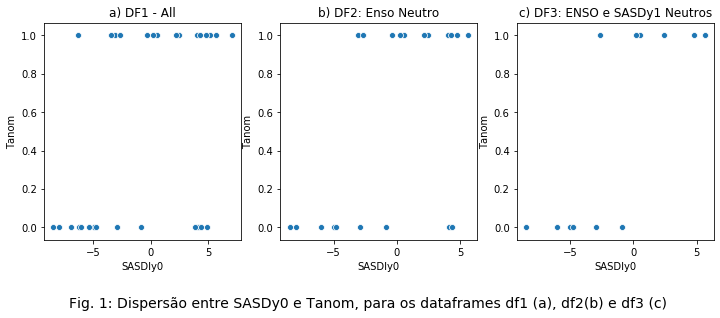

In [5]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,4))  

sns.scatterplot(x='SASDIy0', y='Tanom',data=df1,ax=ax1)
ax1.set_title('a) DF1 - All')
sns.scatterplot(x='SASDIy0', y='Tanom',data=df2,ax=ax2)
ax2.set_title('b) DF2: Enso Neutro')
sns.scatterplot(x='SASDIy0', y='Tanom',data=df3,ax=ax3)
ax3.set_title('c) DF3: ENSO e SASDy1 Neutros')
txt='Fig. 1: Dispersão entre SASDy0 e Tanom, para os dataframes df1 (a), df2(b) e df3 (c)'
null=plt.figtext(0.5, -0.11, txt, wrap=True, horizontalalignment='center', fontsize=14)


<hr>
Acima vemos a distribuição entre SASDIy0 e Tanom. Nota-se que, a medida que a análise é restrita aos eventos neutros de ENSO e SASDy1, fica mais evidente a separação entre valores positivos e negativos de SASDIy0 e as classes de Tanom.
Esse resultado sugere que o ajuste terá melhor desempenho para os dados filtrados, mas haverá menos dados para trabalharmos.

<li></li>
<strong>Obervação:</strong> Não sei se notaram, mas ... multipliquei SASDIy0, ENSO e SASDIy1 por 10. Fiz isso para obter uma melhor vizualização dos Dados Vs Sigmoide. Esse procedimento não interfere na performace do modelo, mas, da forma que está, não podemos comparar os valores dos coeficientes entre si. Para podermos comparar os coeficientes temos que utilizar dados normalizados. Ao longo da análise, forneço os valores dos coeficientes para a análise normalizada. Caso queiram realizar a análise normalizada, descomentem as duas linhas na função "initiate";

<li></li>
Continuando ...

Defino algumas funções para iniciar as variáveis X e Y, incluir Xo=1 no vetor X, e calcular a função sigmoide:

In [6]:
def initiate():
    n_features = len(df.columns)-1 
    X = np.array(df.drop('Tanom',1)) 
    y = df.iloc[:,n_features:n_features+1].values
    scaler = StandardScaler()
#    scaler.fit(X)
#    X = scaler.transform(X)
    return n_features, X, y

Importante adicionar o $X_0=1$ em X, para que possamos multiplicar os vetores $X$ e $\beta$. Faço isso com a função abaixo:

In [7]:
def insert_ones(X):
    ones = np.ones([X.shape[0],1])
    return np.concatenate((ones,X),axis=1)

Vamos definiar a função sigmoid, que usaremos para vizualizar o ajuste.

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

<hr>


<h1> Muito bem... </h1>

Vamos calcular a Regressão Logistica utilizando bibliotecas específicas, para obtermos algumas informações estatísticas relevantes acerca dos resultados.
<li></li>
Primeiro para o df1:

In [9]:
modelo = smf.glm(formula='Tanom ~ SASDIy0 + SASDIy1+ ENSO', data=df1,
                family = sm.families.Binomial()).fit()
print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Tanom   No. Observations:                   29
Model:                            GLM   Df Residuals:                       25
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.787
Date:                Fri, 25 Feb 2022   Deviance:                       33.574
Time:                        14:34:05   Pearson chi2:                     29.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1089      0.518     -0.210      0.8

<hr>Agora para o df2:

In [10]:

modelo = smf.glm(formula='Tanom ~ SASDIy0 + SASDIy1+ ENSO', data=df2,
                family = sm.families.Binomial()).fit()
print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Tanom   No. Observations:                   20
Model:                            GLM   Df Residuals:                       16
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8.7504
Date:                Fri, 25 Feb 2022   Deviance:                       17.501
Time:                        14:34:05   Pearson chi2:                     32.6
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0889      0.649      0.137      0.8

<hr>
Não incluo o df3 pois, como podemos ver na Figura 1, os valores positivos de SASDIy0 resultam todos em Tanom=1. Dessa forma o algoritmo que otimiza os coeficientes não converge e uma mensagem de erro "Perfec separation" é acionada.

<li></li>
<strong>Mas, notemos:</strong>

- Apenas SASDIy0 apresentou p < 0.05, indicando que há evidências de que seu coeficiente é estatisticamente diferente de zero, com um grau de significância de 5%;

- Como as variáveis em X não foram normalizadas, não podemos comparar seus coeficiêntes. Contudo, se o fossem, os resultados para df1 seriam:

    - $\beta_1=1.03$
    - $\beta_2=-0.23$
    - $\beta_3=0.43$

Os coeficientes para os valores normalizados nos informam que SASDIy0 é o termo que mais contribui com o ajuste.

<hr>

Vamos refazer o ajuste, mas agora utilizando o <strong> sklearn</strong>.


<strong>Outro ponto...</strong> Vou utilizar apenas a variável independente SASDy0, pois foi a única com coeficiente estatisticamente significante.

In [11]:
y1 = df1.Tanom
X1 = pd.get_dummies(df1[['SASDIy0']], drop_first=True)

y2 = df2.Tanom
X2 = pd.get_dummies(df2[['SASDIy0']], drop_first=True)

y3 = df3.Tanom
X3 = pd.get_dummies(df3[['SASDIy0']], drop_first=True)



In [12]:

def LogReg_sklearn(X,y):
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    print(classification_report(y, model.predict(X)))
    w=np.append(model.intercept_.ravel(), model.coef_)
    return w
    
  
    
print('---'*20)
print('--- DF1:')
w1=LogReg_sklearn(X1,y1)
print('---'*20)
print('--- DF2:')
w2=LogReg_sklearn(X2,y2)
print('---'*20)
print('--- DF3:')
w3=LogReg_sklearn(X3,y3)


------------------------------------------------------------
--- DF1:
              precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.69      0.73      0.71        15

    accuracy                           0.69        29
   macro avg       0.69      0.69      0.69        29
weighted avg       0.69      0.69      0.69        29

------------------------------------------------------------
--- DF2:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.75      0.82      0.78        11

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20

------------------------------------------------------------
--- DF3:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83    

<hr>
<strong>Acurácia</strong> : Indica a performace geral do modelo de classificação. Dentre todos os eventos, quantos o modelo classificou corretamente 

$$acurácia =\frac{TP+TN}{FP+TP+FN+TN}$$

<strong>Precisão </strong>: Dentre todos os eventos positivos, quantos o modelo acertou sua classificação.

$$precisao =\frac{TP}{FP+TP}$$


<strong>Recall</strong>: A proporção das classificações Positivas que foram corretamente identificadas
$$recall =\frac{TP}{FN+TP}$$



<hr>
<strong> Vejamos ... </strong>

De forma aproximada, temos que o resultado geral de acurácia, precisão e recall é de:

- 70% para df1;
- 75% para df2 (sem eventos intensos de ENSO no ano 1);
- 80% para df3 (sem eventos intensos de ENSO e SASD no ano 1)

<hr>
<strong>Vamos</strong> agora utilizar a metodologia de treino e teste de modelos de Aprendizado de Máquina. Quero dizer: Vamos separar os dados em duas amostras: 

- TREINO: amostra para obtermos a função de ajuste (treinar o modelo)
- TESTE: amostra para testar o modelo.

Fazemos isso para que o treino não seja feito com os dados utilizados na otimização dos coeficientes da função regressora.


Entretanto, a escolha dos conjuntos de Treino e Teste influencia no resultado em si, sobretudo em casos de amostras pequenas, como é o caso aqui.
Para contornar esse problema, o que faço é gerar 1000 ajustes diferentes, mudando as amostras de treino e teste, obtendo distribuições da acurácia, precisão e recall.  Os resultados abaixo mostram a distribuição da performace do modelo ao mudarmos aleatoriamente as amostras.



In [13]:
def reglog(X,y):
    nresample=1000
    score=np.zeros(nresample)
    acuracia=np.zeros(nresample)
    precisao=np.zeros(nresample)
    recall=np.zeros(nresample)
    for rand in range(0,nresample):
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        model = LogisticRegression(random_state=rand,solver='liblinear')
    #random_stateint, RandomState instance, default=None

    #Used when solver == ‘sag’, ‘saga’ or ‘liblinear’
    
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        recall[rand]=recall_score(y_test, y_pred, zero_division=0)
        acuracia[rand]=accuracy_score(y_test, y_pred)
        precisao[rand]=precision_score(y_test, y_pred, zero_division=0)
        metricas = pd.DataFrame({'Score':score,'Acuracia':acuracia,'Precisao':precisao,'Recall':recall})
    return metricas

metricas1=reglog(X1,y1)
metricas2=reglog(X2,y2)
metricas3=reglog(X3,y3)


DF1  Acur. Prec. Rec.:   0.67   0.70   0.69
DF2  Acur. Prec. Rec.:   0.73   0.75   0.78
DF3  Acur. Prec. Rec.:   0.85   0.78   0.75


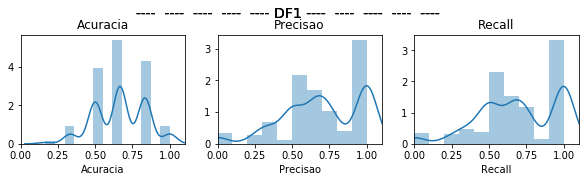

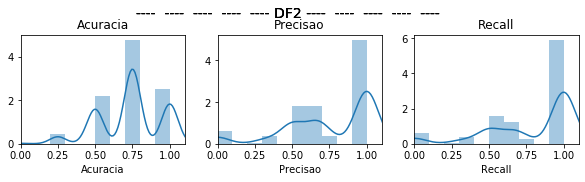

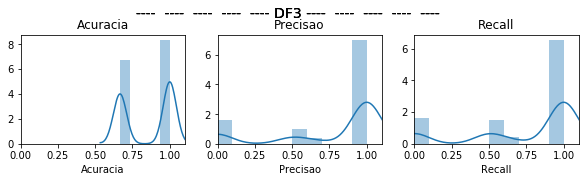

In [14]:
#metricas = pd.DataFrame({'Score':score,'Acuracia':acuracia,'Precisao':precisao,'Recall':recall})
features=('Acuracia','Precisao','Recall')
def makefig(metrica,dfname):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
    for col, ax in zip(features, axs.ravel()):
        x=metrica.loc[:,col]
        sns.distplot(x, ax=ax)
        ax.set_title(col)
        ax.set_xlim([0,1.1])
        txt=' ---- '*5+dfname+' ---- '*5
        null=plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=14)
    print(dfname,' Acur. Prec. Rec.:','% 6.2f' % metrica['Acuracia'].mean(),'% 6.2f' % metrica['Precisao'].mean(),'% 6.2f' % metrica['Recall'].mean())

        #    sns.distplot(x=metricas,x=col,bins=bins,ax=axs)
        
makefig(metricas1,'DF1')
makefig(metricas2,'DF2')
makefig(metricas3,'DF3')

<hr>
Para o conjunto de teste, temos uma performace geral de aproximadamente:

-    70% para df1;
-    75% para df2 (sem eventos intensos de ENSO no ano 1);
-    75-80% para df3 (sem eventos intensos de ENSO e SASD no ano 1)



<hr>
<h1>Até aqui, podemos dizer que ...</h1>

O ajuste atravéz de regressão logistica apresentou uma performace acima de aproximadamente 70%, chegando a cerca de 80% para situações de neutralidade de ENSO e SASDy1. Embora não sejam números expressivamente bons, quando comparados com exemplos típicos de estudos em machine learning, vale notar que a previsibilidade sazonal tem ainda limitações temporais e espaciais bastante significativas, de forma que 70% de precião e recall para uma previsão de 12 meses é um resultado bastante interessante. É importante também notar que, embora ENSO e SASD sejam conhecidos por seus efeitos no clima regional, o modelo regressor apontou para o SASDI_y0 como seu principal componente. Esses resultados evidenciam a importancia do SASD memory effect para o clima regional do sudeste brasileiro e seu real potencial na aplicação como índice preditivo.

<hr>Por fim, vamos vizualizar o ajuste da função sigmoidal para um dos (dos muitos possíveis) conjuntos de dados de treino para df1, df2 e df3.

Aqui tenho que inserir $X_0=1$ nos vetores X1, X2 e X3, para poder multiplicar pela transposta de $\beta$...

In [15]:
X1 = insert_ones(X1)
X2 = insert_ones(X2)
X3 = insert_ones(X3)


>>


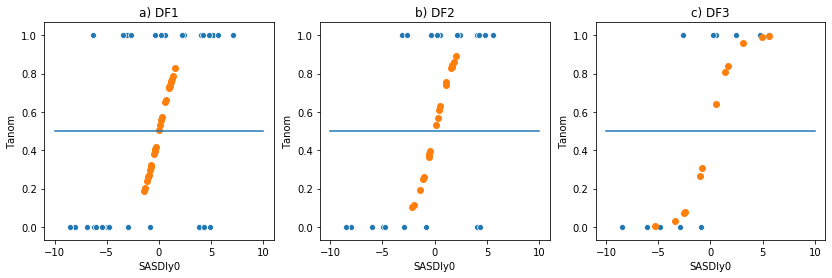

In [16]:
#w = np.append(model.intercept_.ravel(), model.coef_)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(14,4))  
ax=sns.scatterplot(x='SASDIy0', y='Tanom',data=df1,ax=ax1)
ax1.scatter(np.array(X1 @ w1.T), np.array(sigmoid(X1 @ w1.T)))
ax1.plot([-10,10],[0.5,0.5])
ax1.set_title('a) DF1')

ax2=sns.scatterplot(x='SASDIy0', y='Tanom',data=df2,ax=ax2)
ax2.scatter(np.array(X2 @ w2.T), np.array(sigmoid(X2 @ w2.T)))
ax2.plot([-10,10],[0.5,0.5])
ax2.set_title('b) DF2')

ax3=sns.scatterplot(x='SASDIy0', y='Tanom',data=df3,ax=ax3)
ax3.scatter(np.array(X3 @ w3.T), np.array(sigmoid(X3 @ w3.T)))
ax3.plot([-10,10],[0.5,0.5])
ax3.set_title('c) DF3')
print('>>')
#ax.set_xlim([-2,2])

#ax.scatter(df['SASDIy0'], df['Tanom'])
#ax=sns.scatterplot(x=X[:,1], y='Tanom',data=df,ax=ax)

<hr>
<h1><strong>Considerações Finais </strong></h1>
Vimos que os ajustes apresentam perfomaces que são bastante interessantes, dada a natureza do problema e as limitações existentes nas previsões sazonais.
Observamos uma melhoria na performace de 70% para 80%, ao tratarmos apenas situações neutras de ENSO e SASD julho do ano 1. Entretanto, com a filtragem, há uma redução na quantidade de dados, que já era demasiadamente pequena. Realizar esse tipo de análise esbarra imediatamente no limite temporal dos dados observacionais, o que prejudica as etapas de treino e teste devido ao tamanho pequeno das amostras de dados. A utilização de dados de reanálises, por exemplo, poderia ser uma alternativa, mas o viés presente nesses tipos de dados, sobretudo anteriormente ao início das observações por satélite, compromete sua utilização. O uso de bases de dados observacionais seria o ideal, mas recaem em problema semelhante, uma vez que ha pouca amostragem espacial antes de 1980, sobretudo no hemisfério sul. Os resultados apresentados aqui, apesar de esbarrar no problema de escasses de dados, apresentam-se promissores com relação à utilização do SASD memory effect como índice preditor. Será necessário, entretanto, acompanhar a performace do modelo preditor à medida que as séries observacionais aumentam com o tempo.

<strong>Pontos de destaque</strong>

- Ajuste com cerca de 70-80% de Acurácia,Precisão e Recall;
- SASD memory effect foi o principal parâmetro preditor das anomalias de temperatura;
- Cobertura temporal do conjunto de dados observacionais ainda relativamente pequena;

